In [285]:
# Import necessary libraries
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pandas import json_normalize
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# Show full column width 
pd.set_option('display.max_colwidth', None)  # Display full cell content
pd.set_option('display.max_columns', None)  # Show all columns

# 1. Data Loading and Initial Cleaning 

In this section, I loaded the JSON files, performed initial data cleaning, and transformed the data into a structured tabular format. To enhance readability and support a relational data model, the 'receipts' file was split into two separate tables: Receipts and ItemList.

### 1.1 receipts Table

In [57]:
# Read in receipts file
receipts = pd.read_json('receipts.json', lines=True)
receipts

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
0,{'$oid': '5ff1e1eb0a720f0523000575'},500.0,"Receipt number 2 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687531000},{'$date': 1609687536000},{'$date': 1609687531000},500.0,{'$date': 1609632000000},5.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '26.00', 'itemPrice': '26.00', 'needsFetchReview': False, 'partnerItemId': '1', 'preventTargetGapPoints': True, 'quantityPurchased': 5, 'userFlaggedBarcode': '4011', 'userFlaggedNewItem': True, 'userFlaggedPrice': '26.00', 'userFlaggedQuantity': 5}]",FINISHED,26.00,5ff1e1eacfcf6c399c274ae6
1,{'$oid': '5ff1e1bb0a720f052300056b'},150.0,"Receipt number 5 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687483000},{'$date': 1609687488000},{'$date': 1609687483000},150.0,{'$date': 1609601083000},2.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '1', 'itemPrice': '1', 'partnerItemId': '1', 'quantityPurchased': 1}, {'barcode': '028400642255', 'description': 'DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ', 'finalPrice': '10.00', 'itemPrice': '10.00', 'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '2', 'pointsNotAwardedReason': 'Action not allowed for user and CPG', 'pointsPayerId': '5332f5fbe4b03c9a25efd0ba', 'preventTargetGapPoints': True, 'quantityPurchased': 1, 'rewardsGroup': 'DORITOS SPICY SWEET CHILI SINGLE SERVE', 'rewardsProductPartnerId': '5332f5fbe4b03c9a25efd0ba', 'userFlaggedBarcode': '028400642255', 'userFlaggedDescription': 'DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ', 'userFlaggedNewItem': True, 'userFlaggedPrice': '10.00', 'userFlaggedQuantity': 1}]",FINISHED,11.00,5ff1e194b6a9d73a3a9f1052
2,{'$oid': '5ff1e1f10a720f052300057a'},5.0,All-receipts receipt bonus,{'$date': 1609687537000},{'$date': 1609687537000},NaN,{'$date': 1609687542000},NaN,5.0,{'$date': 1609632000000},1.0,"[{'needsFetchReview': False, 'partnerItemId': '1', 'preventTargetGapPoints': True, 'userFlaggedBarcode': '4011', 'userFlaggedNewItem': True, 'userFlaggedPrice': '26.00', 'userFlaggedQuantity': 3}]",REJECTED,10.00,5ff1e1f1cfcf6c399c274b0b
3,{'$oid': '5ff1e1ee0a7214ada100056f'},5.0,All-receipts receipt bonus,{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687534000},{'$date': 1609687539000},{'$date': 1609687534000},5.0,{'$date': 1609632000000},4.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '28.00', 'itemPrice': '28.00', 'needsFetchReview': False, 'partnerItemId': '1', 'preventTargetGapPoints': True, 'quantityPurchased': 4, 'userFlaggedBarcode': '4011', 'userFlaggedNewItem': True, 'userFlaggedPrice': '28.00', 'userFlaggedQuantity': 4}]",FINISHED,28.00,5ff1e1eacfcf6c399c274ae6
4,{'$oid': '5ff1e1d20a7214ada1000561'},5.0,All-receipts receipt bonus,{'$date': 1609687506000},{'$date': 1609687506000},{'$date': 1609687511000},{'$date': 1609687511000},{'$date': 1609687506000},5.0,{'$date': 1609601106000},2.0,"[{'barcode': '4011', 'description': 'ITEM NOT FOUND', 'finalPrice': '1', 'itemPrice': '1', 'partnerItemId': '1', 'quantityPurchased': 1}, {'barcode': '1234', 'finalPrice': '2.56', 'itemPrice': '2.56', 'needsFetchReview': True, 'needsFetchReviewReason': 'USER_FLAGGED', 'partnerItemId': '2', 'preventTargetGapPoints': True, 'quantityPurchased': 3, 'userFlaggedBarcode': '1234', 'userFlaggedDescription': '', 'userFlaggedNewItem': True, 'userFlaggedPrice': '2.56', 'userFlaggedQuantity': 3}]",FINISHED,1.00,5ff1e194b6a9d73a3a9f1052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,{'$oid': '603cc0630a720fde100003e6'},25.0,COMPLETE_NONPARTNER_RECEIPT,{'$date': 16145

In [95]:
# Function to normalize date and oid fields
def normalize_json_fields(record):
    if isinstance(record, dict):
        if "$oid" in record:
            return record["$oid"]
        elif "$date" in record:
            return pd.to_datetime(record["$date"], unit="ms")  # Convert timestamp to readable format
    return record 

# Normalize all columns
for col in receipts.columns:
    receipts[col] = receipts[col].apply(normalize_json_fields)

# Create a copy with all columns, including rewardsReceiptItemList
receipts_copy = receipts.copy()
    
# Drop rewardsReceiptItemList column from receipts table as rewardsReceiptItemList will be normalized into itemList table
receipts.drop('rewardsReceiptItemList', axis = 1, inplace = True)

In [96]:
receipts

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptStatus,totalSpent,userId
0,5ff1e1eb0a720f0523000575,500.0,"Receipt number 2 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-03 15:25:31.000,2021-01-03 15:25:31.000,2021-01-03 15:25:31,2021-01-03 15:25:36.000,2021-01-03 15:25:31,500.0,2021-01-03 00:00:00,5.0,FINISHED,26.00,5ff1e1eacfcf6c399c274ae6
1,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-03 15:24:43.000,2021-01-03 15:24:43.000,2021-01-03 15:24:43,2021-01-03 15:24:48.000,2021-01-03 15:24:43,150.0,2021-01-02 15:24:43,2.0,FINISHED,11.00,5ff1e194b6a9d73a3a9f1052
2,5ff1e1f10a720f052300057a,5.0,All-receipts receipt bonus,2021-01-03 15:25:37.000,2021-01-03 15:25:37.000,NaT,2021-01-03 15:25:42.000,NaT,5.0,2021-01-03 00:00:00,1.0,REJECTED,10.00,5ff1e1f1cfcf6c399c274b0b
3,5ff1e1ee0a7214ada100056f,5.0,All-receipts receipt bonus,2021-01-03 15:25:34.000,2021-01-03 15:25:34.000,2021-01-03 15:25:34,2021-01-03 15:25:39.000,2021-01-03 15:25:34,5.0,2021-01-03 00:00:00,4.0,FINISHED,28.00,5ff1e1eacfcf6c399c274ae6
4,5ff1e1d20a7214ada1000561,5.0,All-receipts receipt bonus,2021-01-03 15:25:06.000,2021-01-03 15:25:06.000,2021-01-03 15:25:11,2021-01-03 15:25:11.000,2021-01-03 15:25:06,5.0,2021-01-02 15:25:06,2.0,FINISHED,1.00,5ff1e194b6a9d73a3a9f1052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,603cc0630a720fde100003e6,25.0,COMPLETE_NONPARTNER_RECEIPT,2021-03-01 10:22:27.000,2021-03-01 10:22:27.000,NaT,2021-03-01 10:22:28.000,NaT,25.0,2020-08-17 00:00:00,2.0,REJECTED,34.96,5fc961c3b8cfca11a077dd33
1115,603d0b710a720fde1000042a,NaN,NaN,2021-03-01 15:42:41.873,2021-03-01 15:42:41.873,NaT,2021-03-01 15:42:41.873,NaT,NaN,NaT,NaN,SUBMITTED,NaN,5fc961c3b8cfca11a077dd33
1116,603cf5290a720fde10000413,NaN,NaN,2021-03-01 14:07:37.664,2021-03-01 14:07:37.664,NaT,2021-03-01 14:07:37.664,NaT,NaN,NaT,NaN,SUBMITTED,NaN,5fc961c3b8cfca11a077dd33
1117,603ce7100a7217c72c000405,25.0,COMPLETE_NONPARTNER_RECEIPT,2021-03-01 13:07:28.000,2021-03-01 13:07:28.000,NaT,2021-03-01 13:07:29.000,NaT,25.0,2020-08-17 00:00:00,2.0,REJECTED,34.96,5fc961c3b8cfca11a077dd33


### 1.2 itemList Table

In [84]:
# Normalize the rewardsReceiptItemList from receipts table and convert it into a separate itemList table 

# Select needed columns from receipts table
receipts_copy = receipts_copy.dropna(subset=['rewardsReceiptItemList'])[['_id','rewardsReceiptItemList']].copy()

# Explode the list of dictionaries into separate rows
df_exploded = receipts_copy.explode("rewardsReceiptItemList").reset_index(drop=True)

# Convert dict values into columns and rows
df_flattened = df_exploded["rewardsReceiptItemList"].apply(pd.Series)

# Merge expanded data with id column
itemList = pd.concat([df_exploded.drop(columns=["rewardsReceiptItemList"]), df_flattened], axis=1)


itemList

,_id,barcode,description,finalPrice,itemPrice,needsFetchReview,partnerItemId,preventTargetGapPoints,quantityPurchased,userFlaggedBarcode,userFlaggedNewItem,userFlaggedPrice,userFlaggedQuantity,needsFetchReviewReason,pointsNotAwardedReason,pointsPayerId,rewardsGroup,rewardsProductPartnerId,userFlaggedDescription,originalMetaBriteBarcode,originalMetaBriteDescription,brandCode,competitorRewardsGroup,discountedItemPrice,originalReceiptItemText,itemNumber,originalMetaBriteQuantityPurchased,pointsEarned,targetPrice,competitiveProduct,originalFinalPrice,originalMetaBriteItemPrice,deleted,priceAfterCoupon,metabriteCampaignId
0,5ff1e1eb0a720f0523000575,4011,ITEM NOT FOUND,26.00,26.00,False,1,True,5.0,4011,True,26.00,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5ff1e1bb0a720f052300056b,4011,ITEM NOT FOUND,1,1,NaN,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5ff1e1bb0a720f052300056b,028400642255,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ,10.00,10.00,True,2,True,1.0,028400642255,True,10.00,1.0,USER_FLAGGED,Action not allowed for user and CPG,5332f5fbe4b03c9a25efd0ba,DORITOS SPICY SWEET CHILI SINGLE SERVE,5332f5fbe4b03c9a25efd0ba,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5ff1e1f10a720f052300057a,NaN,NaN,NaN,NaN,False,1,True,NaN,4011,True,26.00,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5ff1e1ee0a7214ada100056f,4011,ITEM NOT FOUND,28.00,28.00,False,1,True,4.0,4011,True,28.00,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6936,603cc2bc0a720fde100003e9,B07BRRLSVC,thindust summer face mask - sun protection neck gaiter for outdooractivities,11.99,11.99,NaN,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.99,thindust summer face mask - sun protection neck gaiter for outdooractivities,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.99,NaN
6937,603cc0630a720fde100003e6,B076FJ92M4,"mueller austria hypergrind precision electric spice/coffee grinder millwith large grinding capacity and hd motor also for spices, herbs, nuts,grains, white",22.97,22.97,NaN,0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.97,"mueller austria hypergrind precision electric spice/coffee grinder millwith large grinding capacity and hd motor also for spices, herbs, nuts,grains, white",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.97,NaN
6938,603cc0630a720fde100003e6,B07BRRLSVC,thindust summer face mask - sun protection neck gaiter for outdooractivities,11.99,11.99,NaN,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.99,thindust summer face mask - sun protection neck gaiter for outdooractivities,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.99,NaN
6939,603ce7100a7217c72c000405,B076FJ92M4,"mueller austria hypergrind precision electric spice/coffee grinder millwith large grinding capacity and hd motor also for spices, herbs, nuts,grains, white",22.97,22.97,NaN,0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.97,"mueller austria hypergrind precision electric spice/coffee grinder millwith large grinding capacity and hd motor also for spices, herbs, nuts,grains, white",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.97,NaN


### 1.3 users Table

In [85]:
# Read in receipts file
users = pd.read_json('users.json', lines=True)

# Normalize all columns
for col in users.columns:
    users[col] = users[col].apply(normalize_json_fields)
   

users

,_id,active,createdDate,lastLogin,role,signUpSource,state
0,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
1,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
2,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
3,5ff1e1eacfcf6c399c274ae6,True,2021-01-03 15:25:30.554,2021-01-03 15:25:30.597,consumer,Email,WI
4,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
...,...,...,...,...,...,...,...
490,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204,fetch-staff,NaN,NaN
491,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204,fetch-staff,NaN,NaN
492,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204,fetch-staff,NaN,NaN
493,54943462e4b07e684157a532,True,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204,fetch-staff,NaN,NaN


### 1.4 brands Table

In [77]:
# Read in receipts file
brands = pd.read_json('brands.json', lines=True)
brands


for col in brands.columns:
     brands[col] = brands[col].apply(normalize_json_fields)

   
# Extract CPG id and reference 
brands["cpg_id"] = brands["cpg"].apply(lambda x: x.get("$id", {}).get("$oid") if isinstance(x, dict) else None)
brands["cpg_ref"] = brands["cpg"].apply(lambda x: x.get("$ref") if isinstance(x, dict) else None)

# Drop original nested column
brands.drop(columns=["cpg"], inplace=True)


brands

,_id,barcode,category,categoryCode,name,topBrand,brandCode,cpg_id,cpg_ref
0,601ac115be37ce2ead437551,511111019862,Baking,BAKING,test brand @1612366101024,0.0,NaN,601ac114be37ce2ead437550,Cogs
1,601c5460be37ce2ead43755f,511111519928,Beverages,BEVERAGES,Starbucks,0.0,STARBUCKS,5332f5fbe4b03c9a25efd0ba,Cogs
2,601ac142be37ce2ead43755d,511111819905,Baking,BAKING,test brand @1612366146176,0.0,TEST BRANDCODE @1612366146176,601ac142be37ce2ead437559,Cogs
3,601ac142be37ce2ead43755a,511111519874,Baking,BAKING,test brand @1612366146051,0.0,TEST BRANDCODE @1612366146051,601ac142be37ce2ead437559,Cogs
4,601ac142be37ce2ead43755e,511111319917,Candy & Sweets,CANDY_AND_SWEETS,test brand @1612366146827,0.0,TEST BRANDCODE @1612366146827,5332fa12e4b03c9a25efd1e7,Cogs
...,...,...,...,...,...,...,...,...,...
1162,5f77274dbe37ce6b592e90c0,511111116752,Baking,BAKING,test brand @1601644365844,NaN,NaN,5f77274dbe37ce6b592e90bf,Cogs
1163,5dc1fca91dda2c0ad7da64ae,511111706328,Breakfast & Cereal,NaN,Dippin Dots® Cereal,NaN,DIPPIN DOTS CEREAL,53e10d6368abd3c7065097cc,Cogs
1164,5f494c6e04db711dd8fe87e7,511111416173,Candy & Sweets,CANDY_AND_SWEETS,test brand @1598639215217,NaN,TEST BRANDCODE @1598639215217,5332fa12e4b03c9a25efd1e7,Cogs
1165,5a021611e4b00efe02b02a57,511111400608,Grocery,NaN,LIPTON TEA Leaves,0.0,LIPTON TEA Leaves,5332f5f6e4b03c9a25efd0b4,Cogs


# 2. Write queries that directly answer questions from business stakeholders

### ( *All the SQL questions below are answered using Snowflake SQL syntanx)

### Question 1: What are the top 5 brands by receipts scanned for most recent month (most recent month in data provided)?

In [168]:
"""

with filtered_receipts AS (
    -- select receipts only from the current month
    SELECT r._id, i.barcode
    FROM receipts r
    JOIN itemlist i ON r._id = i._id
    WHERE DATE_TRUNC('month', r.dateScanned) = DATE_TRUNC('month', CURRENT_DATE)
)

SELECT 
    b.name AS brand_name,
    COUNT(DISTINCT f._id) AS receipts_cnt
FROM filtered_receipts f
JOIN brands b ON f.barcode = b.barcode
WHERE b.name IS NOT NULL
GROUP BY 1
ORDER BY receipts_cnt DESC
LIMIT 5
;

"""

"\n\nwith filtered_receipts AS (\n    -- select receipts only from the current month\n    SELECT r._id, i.barcode\n    FROM receipts r\n    JOIN itemlist i ON r._id = i._id\n    WHERE DATE_TRUNC('month', r.dateScanned) = DATE_TRUNC('month', CURRENT_DATE)\n)\n\nSELECT \n    b.name AS brand_name,\n    COUNT(DISTINCT f._id) AS receipts_cnt\nFROM filtered_receipts f\nJOIN brands b ON f.barcode = b.barcode\nWHERE b.name IS NOT NULL\nGROUP BY 1\nORDER BY receipts_cnt DESC\nLIMIT 5\n;\n\n"

### Question 2: How does the ranking of the top 5 brands by receipts scanned for the recent month compare to the ranking for the previous month?

In [162]:
"""

-- count receipts for each brand each month
WITH brand_receipts_cnt AS (
    SELECT
        DATE_TRUNC('month', r.dateScanned) as mnth,
        b.name AS brand_name,
        COUNT(DISTINCT r._id) AS receipts_cnt
    FROM receipts r
    LEFT JOIN itemlist i on r._id = i._id
    LEFT JOIN brands b on i.barcode = b.barcode
    WHERE b.name IS NOT NULL
    GROUP BY 1, 2
),

-- rank brand by receipts in each month
brand_rank AS (
    SELECT 
        *,
        RANK() OVER(PARTITION BY mnth ORDER BY receipts_cnt DESC) rnk
    FROM brand_receipts_cnt   
)


SELECT 
    r1.brand_name,
    r1.mnth AS current_mnth,
    r1.rnk AS current_mnth_rnk,
    r2.mnth AS prev_mnth,
    r2.rnk AS prev_mnth_rnk

-- find top 5 brand in current month
FROM (SELECT * FROM brand_rank WHERE mnth = DATE_TRUNC('month', CURRENT_DATE) AND rnk <= 5) r1
-- join to the same brands in the previous month
LEFT JOIN (SELECT * FROM brand_rank WHERE mnth = DATE_TRUNC('month', DATEADD('month', -1, CURRENT_DATE))) r2
ON r1.brand_name = r2.brand_name


"""

"\n\n-- count receipts for each brand each month\nWITH brand_receipts_cnt AS (\n    SELECT\n        DATE_TRUNC('month', r.dateScanned) as mnth,\n        b.name AS brand_name,\n        COUNT(DISTINCT r._id) AS receipts_cnt\n    FROM receipts r\n    LEFT JOIN itemlist i on r._id = i._id\n    LEFT JOIN brands b on i.barcode = b.barcode\n    WHERE b.name IS NOT NULL\n    GROUP BY 1, 2\n),\n\n-- rank brand by receipts in each month\nbrand_rank AS (\n    SELECT \n        *,\n        RANK() OVER(PARTITION BY mnth ORDER BY receipts_cnt DESC) rnk\n    FROM brand_receipts_cnt   \n)\n\n\nSELECT \n    r1.brand_name,\n    r1.mnth AS current_mnth,\n    r1.rnk AS current_mnth_rnk,\n    r2.mnth AS prev_mnth,\n    r2.rnk AS prev_mnth_rnk\n\n-- find top 5 brand in current month\nFROM (SELECT * FROM brand_rank WHERE mnth = DATE_TRUNC('month', CURRENT_DATE) AND rnk <= 5) r1\n-- join to the same brands in the previous month\nLEFT JOIN (SELECT * FROM brand_rank WHERE mnth = DATE_TRUNC('month', DATEADD('mont

### Question 3: When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

In [161]:
"""

SELECT 
    rewardsReceiptStatus, 
    AVG(totalSpent) AS avg_spent
FROM receipts
WHERE rewardsReceiptStatus IN ('Accepted', 'Rejected')
GROUP BY rewardsReceiptStatus
ORDER BY avg_spent DESC;


"""

"\n\nSELECT \n    rewardsReceiptStatus, \n    AVG(totalSpent) AS avg_spent\nFROM receipts\nWHERE rewardsReceiptStatus IN ('Accepted', 'Rejected')\nGROUP BY rewardsReceiptStatus\nORDER BY avg_spent DESC;\n\n\n"

### Question 4: When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

In [164]:
"""

SELECT 
    rewardsReceiptStatus, 
    SUM(purchasedItemCount) AS total_items_purchased
FROM receipts
WHERE rewardsReceiptStatus IN ('Accepted', 'Rejected')
GROUP BY rewardsReceiptStatus
ORDER BY total_items_purchased DESC;


"""

"\n\nSELECT \n    rewardsReceiptStatus, \n    SUM(purchasedItemCount) AS total_items_purchased\nFROM receipts\nWHERE rewardsReceiptStatus IN ('Accepted', 'Rejected')\nGROUP BY rewardsReceiptStatus\nORDER BY total_items_purchased DESC;\n\n\n"

### Question 5: Which brand has the most spend among users who were created within the past 6 months?

In [ ]:
"""

WITH recent_users AS (
    SELECT DISTINCT _id AS user_id
    FROM users
    -- filter down to users whose createdate is within the past 6 months
    WHERE DATE_TRUNC('month', createdDate) >= DATE_TRUNC('month', DATEADD(month, -6, CURRENT_DATE))
)


SELECT 
    b.name AS brand_name,
    SUM(r.totalspent) as total_spend
FROM recent_users u 
LEFT JOIN receipts r on u.user_id = r.userId
LEFT JOIN itemlist i on r._id = i._id
LEFT JOIN brands b on i.barcode = b.barcode
WHERE b.name IS NOT NULL
GROUP BY 1
ORDER BY total_spend DESC
LIMIT 1

"""

### Question 6: Which brand has the most transactions among users who were created within the past 6 months?

In [ ]:
"""

WITH recent_users AS (
    SELECT DISTINCT _id AS user_id
    FROM users
    -- filter down to users whose createdate is within the past 6 months
    WHERE DATE_TRUNC('month', createdDate) >= DATE_TRUNC('month', DATEADD(month, -6, CURRENT_DATE))
)


SELECT 
    b.name AS brand_name,
    COUNT(DISTINCT r._id) AS transaction_cnt
FROM recent_users u 
LEFT JOIN receipts r on u.user_id = r.userId
LEFT JOIN itemlist i on r._id = i._id
LEFT JOIN brands b on i.barcode = b.barcode
WHERE b.name IS NOT NULL
GROUP BY 1
ORDER BY transaction_cnt DESC
LIMIT 1

"""

# 3. Evaluate Data Quality Issues in the Data Provided

Here, we examine data quality issues across five key aspects:
- Data Types
- Missing Values
- Duplications
- Distributions
- Joining Keys

Detailed findings for each aspect are provided in the respective sections.

### 3.0 Check data types and convert to right types

##### Users Table

Look all good.

In [271]:
print(users.dtypes)
users.head()

_id                     object
active                    bool
createdDate     datetime64[ns]
lastLogin       datetime64[ns]
role                    object
signUpSource            object
state                   object
dtype: object


,_id,active,createdDate,lastLogin,role,signUpSource,state
0,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
1,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
2,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
3,5ff1e1eacfcf6c399c274ae6,True,2021-01-03 15:25:30.554,2021-01-03 15:25:30.597,consumer,Email,WI
4,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI


##### Brands Table

topBrand should be boolean based on instruction provided.

In [273]:
print(brands.dtypes)
brands.head()

_id              object
barcode           int64
category         object
categoryCode     object
name             object
topBrand        float64
brandCode        object
cpg_id           object
cpg_ref          object
dtype: object


,_id,barcode,category,categoryCode,name,topBrand,brandCode,cpg_id,cpg_ref
0,601ac115be37ce2ead437551,511111019862,Baking,BAKING,test brand @1612366101024,0.0,NaN,601ac114be37ce2ead437550,Cogs
1,601c5460be37ce2ead43755f,511111519928,Beverages,BEVERAGES,Starbucks,0.0,STARBUCKS,5332f5fbe4b03c9a25efd0ba,Cogs
2,601ac142be37ce2ead43755d,511111819905,Baking,BAKING,test brand @1612366146176,0.0,TEST BRANDCODE @1612366146176,601ac142be37ce2ead437559,Cogs
3,601ac142be37ce2ead43755a,511111519874,Baking,BAKING,test brand @1612366146051,0.0,TEST BRANDCODE @1612366146051,601ac142be37ce2ead437559,Cogs
4,601ac142be37ce2ead43755e,511111319917,Candy & Sweets,CANDY_AND_SWEETS,test brand @1612366146827,0.0,TEST BRANDCODE @1612366146827,5332fa12e4b03c9a25efd1e7,Cogs


In [282]:
# Convert topBrand to boolean based on data dictionary provided in instruction
brands['topBrand'] = brands['topBrand'].astype(bool)

print(brands.dtypes)

_id             object
barcode          int64
category        object
categoryCode    object
name            object
topBrand          bool
brandCode       object
cpg_id          object
cpg_ref         object
dtype: object


##### Receipts Table

Look all good.

In [274]:
print(receipts.dtypes)
receipts.head()

_id                                object
bonusPointsEarned                 float64
bonusPointsEarnedReason            object
createDate                 datetime64[ns]
dateScanned                datetime64[ns]
finishedDate               datetime64[ns]
modifyDate                 datetime64[ns]
pointsAwardedDate          datetime64[ns]
pointsEarned                      float64
purchaseDate               datetime64[ns]
purchasedItemCount                float64
rewardsReceiptStatus               object
totalSpent                        float64
userId                             object
dtype: object


,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptStatus,totalSpent,userId
0,5ff1e1eb0a720f0523000575,500.0,"Receipt number 2 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:36,2021-01-03 15:25:31,500.0,2021-01-03 00:00:00,5.0,FINISHED,26.0,5ff1e1eacfcf6c399c274ae6
1,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:48,2021-01-03 15:24:43,150.0,2021-01-02 15:24:43,2.0,FINISHED,11.0,5ff1e194b6a9d73a3a9f1052
2,5ff1e1f10a720f052300057a,5.0,All-receipts receipt bonus,2021-01-03 15:25:37,2021-01-03 15:25:37,NaT,2021-01-03 15:25:42,NaT,5.0,2021-01-03 00:00:00,1.0,REJECTED,10.0,5ff1e1f1cfcf6c399c274b0b
3,5ff1e1ee0a7214ada100056f,5.0,All-receipts receipt bonus,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:39,2021-01-03 15:25:34,5.0,2021-01-03 00:00:00,4.0,FINISHED,28.0,5ff1e1eacfcf6c399c274ae6
4,5ff1e1d20a7214ada1000561,5.0,All-receipts receipt bonus,2021-01-03 15:25:06,2021-01-03 15:25:06,2021-01-03 15:25:11,2021-01-03 15:25:11,2021-01-03 15:25:06,5.0,2021-01-02 15:25:06,2.0,FINISHED,1.0,5ff1e194b6a9d73a3a9f1052


##### itemList Table

Several numeric columns are listed as object and need to be converted to the right data type.

In [276]:
print(itemList.dtypes)
itemList.head()

_id                                    object
barcode                                object
description                            object
finalPrice                             object
itemPrice                              object
needsFetchReview                       object
partnerItemId                          object
preventTargetGapPoints                 object
quantityPurchased                     float64
userFlaggedBarcode                     object
userFlaggedNewItem                     object
userFlaggedPrice                       object
userFlaggedQuantity                   float64
needsFetchReviewReason                 object
pointsNotAwardedReason                 object
pointsPayerId                          object
rewardsGroup                           object
rewardsProductPartnerId                object
userFlaggedDescription                 object
originalMetaBriteBarcode               object
originalMetaBriteDescription           object
brandCode                         

,_id,barcode,description,finalPrice,itemPrice,needsFetchReview,partnerItemId,preventTargetGapPoints,quantityPurchased,userFlaggedBarcode,userFlaggedNewItem,userFlaggedPrice,userFlaggedQuantity,needsFetchReviewReason,pointsNotAwardedReason,pointsPayerId,rewardsGroup,rewardsProductPartnerId,userFlaggedDescription,originalMetaBriteBarcode,originalMetaBriteDescription,brandCode,competitorRewardsGroup,discountedItemPrice,originalReceiptItemText,itemNumber,originalMetaBriteQuantityPurchased,pointsEarned,targetPrice,competitiveProduct,originalFinalPrice,originalMetaBriteItemPrice,deleted,priceAfterCoupon,metabriteCampaignId
0,5ff1e1eb0a720f0523000575,4011,ITEM NOT FOUND,26.00,26.00,False,1,True,5.0,4011,True,26.00,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5ff1e1bb0a720f052300056b,4011,ITEM NOT FOUND,1,1,NaN,1,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5ff1e1bb0a720f052300056b,028400642255,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ,10.00,10.00,True,2,True,1.0,028400642255,True,10.00,1.0,USER_FLAGGED,Action not allowed for user and CPG,5332f5fbe4b03c9a25efd0ba,DORITOS SPICY SWEET CHILI SINGLE SERVE,5332f5fbe4b03c9a25efd0ba,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCED FAT BAG 1 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5ff1e1f10a720f052300057a,NaN,NaN,NaN,NaN,False,1,True,NaN,4011,True,26.00,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5ff1e1ee0a7214ada100056f,4011,ITEM NOT FOUND,28.00,28.00,False,1,True,4.0,4011,True,28.00,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [281]:
# Convert selected columns to float

numeric_columns = [
    "finalPrice", "itemPrice", "quantityPurchased", "userFlaggedQuantity", 
    "originalMetaBriteQuantityPurchased", "pointsEarned", "targetPrice", 
    "originalFinalPrice", "originalMetaBriteItemPrice", "discountedItemPrice", 
    "priceAfterCoupon"
]

for col in numeric_columns:
        itemList[col] = pd.to_numeric(itemList[col], errors='coerce')

print(itemList.dtypes)

_id                                    object
barcode                                object
description                            object
finalPrice                            float64
itemPrice                             float64
needsFetchReview                       object
partnerItemId                          object
preventTargetGapPoints                 object
quantityPurchased                     float64
userFlaggedBarcode                     object
userFlaggedNewItem                     object
userFlaggedPrice                       object
userFlaggedQuantity                   float64
needsFetchReviewReason                 object
pointsNotAwardedReason                 object
pointsPayerId                          object
rewardsGroup                           object
rewardsProductPartnerId                object
userFlaggedDescription                 object
originalMetaBriteBarcode               object
originalMetaBriteDescription           object
brandCode                         

### 3.1 Check missing values

#### Users Table

The Users Dataset has minimal missing values. Only lastLogin (13%), signUpSource (10%), and state (11%) have gaps, while all other columns are fully populated. Data completeness is generally strong.

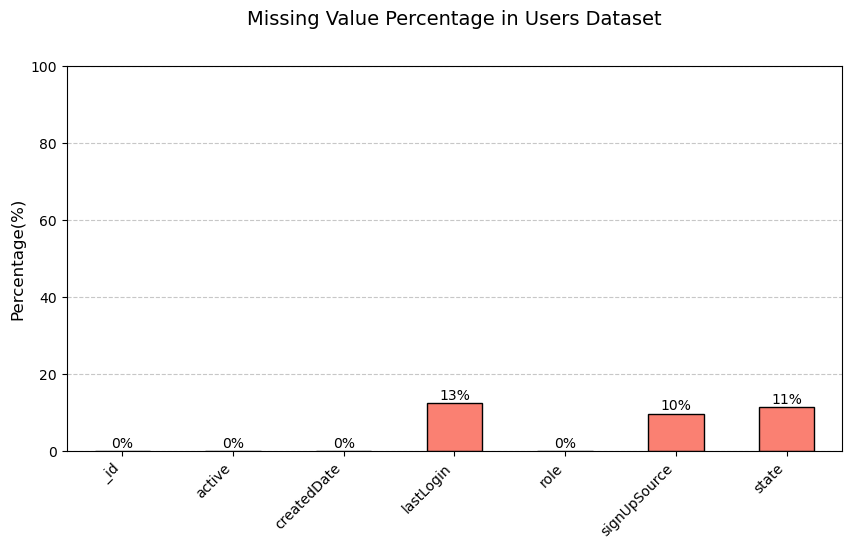

In [363]:
# Define function to calculate missing value percentage
def missing_value_percentage(df):
    return (df.isnull().sum() / len(df) * 100).round(2)

# Function to plot percentage of missing values
def plot_missing_values(df, dataset_name):
    missing_data = missing_value_percentage(df)

    plt.figure(figsize=(10, 5))
    missing_data.plot(kind='bar', color='salmon', edgecolor='black')
    
    plt.title(f"Missing Value Percentage in {dataset_name}", fontsize=14, pad = 30)
    plt.ylabel("Percentage(%)", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Set y-axis limit between 0 and 100
    plt.ylim(0, 100)
    
    # Display percentage values on top of bars
    for index, value in enumerate(missing_data):
        plt.text(index, value + 1, f"{value:.0f}%", ha='center', fontsize=10)

    plt.show()

# Call the function for the 'users' dataset
plot_missing_values(users, "Users Dataset")


#### Brands Table

The Brands Dataset has significant missing values in categoryCode (56%), topBrand (52%), and brandCode (20%), while category has 13% missing data. Other key columns, including barcode, name, and IDs, are fully populated. These gaps may impact brand-level analysis and understanding of popular merchant categories where cusomters spend over.


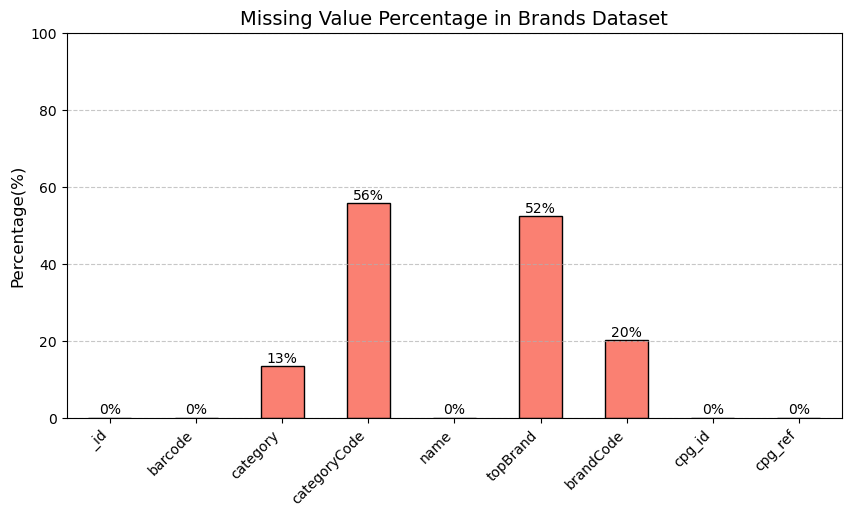

In [216]:
# Call the function for the 'brands' dataset
plot_missing_values(brands, "Brands Dataset")


#### Receipts Table

The Receipts Dataset has significant missing values in key fields: bonusPointsEarned (51%), bonusPointsEarnedReason (51%), pointsAwardedDate (52%), finishedDate (49%), pointsEarned (46%), purchaseDate (40%), purchasedItemCount (43%), totalSpent (39%).

Further analysis shows that most missing values are from receipts with 'SUBMITTED' status, whereas 'FINISHED' receipts have minimal missing data. This suggests that analysis should focus more on processed (FINISHED) receipts for accuracy.


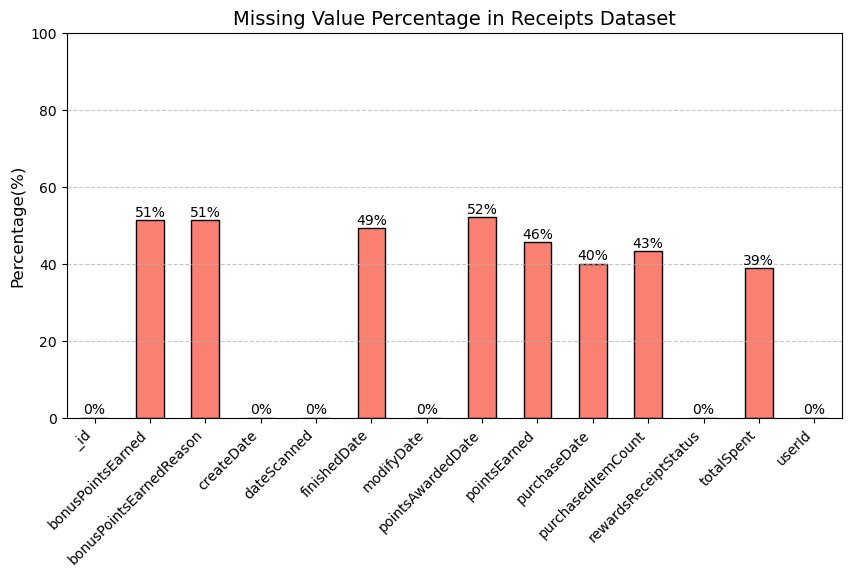

In [215]:
# Call the function for the overall 'receipts' dataset
plot_missing_values(receipts, "Receipts Dataset")


In [370]:
# Check distribution of status column
receipts.rewardsReceiptStatus.value_counts()

rewardsReceiptStatus
FINISHED     518
SUBMITTED    434
REJECTED      71
PENDING       50
FLAGGED       46
Name: count, dtype: int64

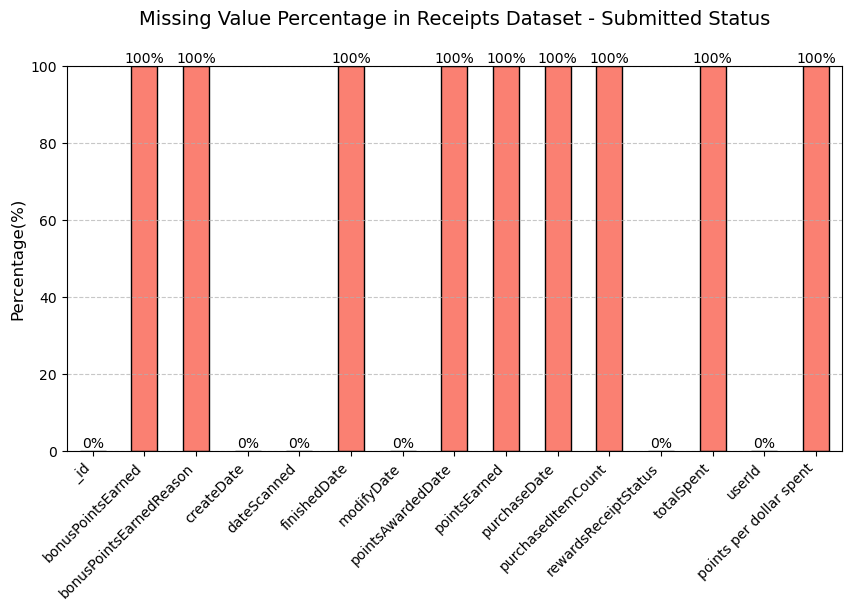

In [371]:
# Call the function for the receipts under 'SUBMITTED' status
plot_missing_values(receipts[receipts['rewardsReceiptStatus']=='SUBMITTED'], "Receipts Dataset - Submitted Status")


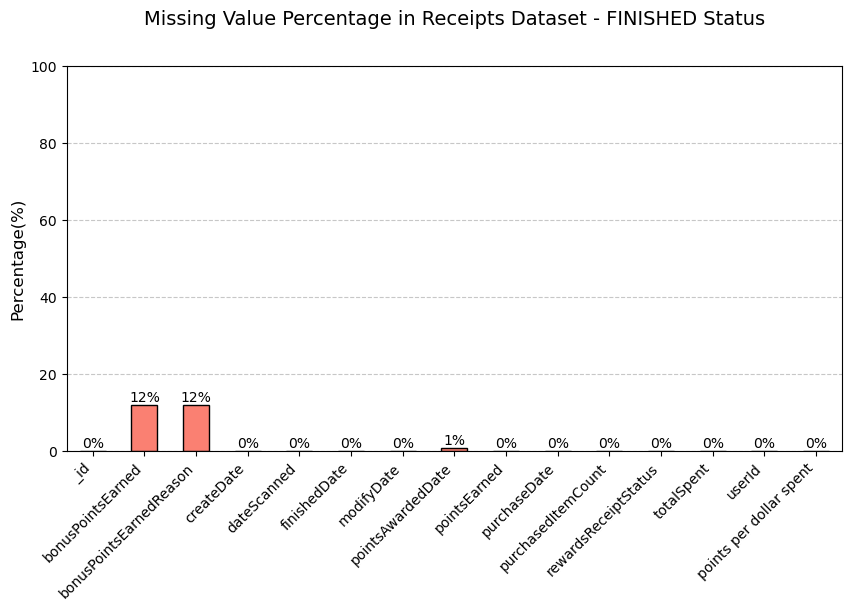

In [372]:
# Call the function for the receipts under 'FINISHED' status
plot_missing_values(receipts[receipts['rewardsReceiptStatus']=='FINISHED'], "Receipts Dataset - FINISHED Status")


#### ItemList Table

The missing value issue in the ItemList table is concerning, as many key columns have a high missing rate:

1. Barcode (55%) – critical for linking to the brands table. missing values limit brand-level analysis.
2. User-flagged columns – userFlaggedPrice (95%) and userFlaggedQuantity (95%) are expected to have high missing rates since flagging is voluntary.
3. Completely missing columns – several fields, including originalMetaBriteItemPrice and priceAfterCoupon, have 100% missing values.




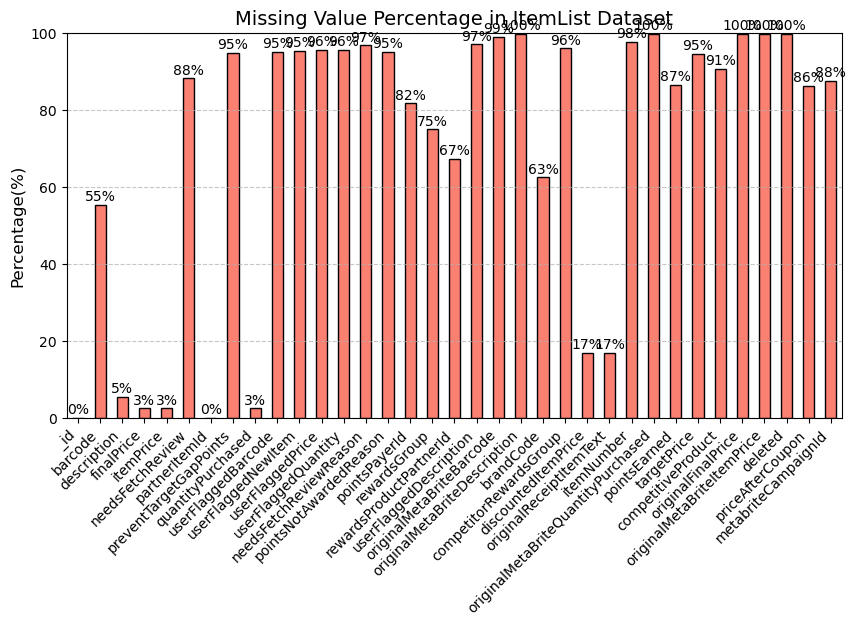

In [214]:
# Call the function for the 'users' dataset
plot_missing_values(itemList, "ItemList Dataset")


### 3.2 Check duplicated values

#### Users

1. 71.31% of records are duplicated in user table. 
2. After de-dup, only 212 unique rows/ids remain.
3. Top 5 most duplicated records have duplication counts ranging from 9 to 20.

In [378]:
def get_top_duplications(df, dataset_name):
    # calculate percentage of duplicated rows
    dup_percent = df.duplicated(keep=False).sum()/len(df)
    print(f"Percentage of duplicated rows in {dataset_name} table:", (dup_percent*100).round(2),  "%\n")
    
    num_unique_rows = df.drop_duplicates().shape[0]
    print('Number of unique records: ',num_unique_rows, '\n')
    
    print(f"Below are top 5 duplicated records")
    
    # find top duplicated rows by count 
    dup_cnt = df[df.duplicated( keep=False)].groupby(df.columns.tolist()).size()
    return dup_cnt.reset_index(name = 'dup_cnt').sort_values(by='dup_cnt', ascending = False).head(5)
    

get_top_duplications(users, 'Users')

Percentage of duplicated rows in Users table: 71.31 %

Number of unique records:  212 

Below are top 5 duplicated records


,_id,active,createdDate,lastLogin,role,signUpSource,state,dup_cnt
0,5fc961c3b8cfca11a077dd33,True,2020-12-03 22:08:03.936,2021-02-26 22:39:16.799,fetch-staff,Email,NH,20
10,5ff5d15aeb7c7d12096d91a2,True,2021-01-06 15:03:54.680,2021-01-06 15:08:10.009,consumer,Email,WI,18
42,600fb1ac73c60b12049027bb,True,2021-01-26 06:07:40.879,2021-01-26 06:11:23.950,consumer,Email,WI,16
1,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI,11
37,600987d77d983a11f63cfa92,True,2021-01-21 13:55:35.327,2021-01-21 13:59:21.063,consumer,Email,WI,9


#### Brands

No duplication.

In [258]:
get_top_duplications(brands, 'Brands')

Percentage of duplicated rows in Brands table: 0.0 %

Below are top 5 duplicated records


,_id,barcode,category,categoryCode,name,topBrand,brandCode,cpg_id,cpg_ref,dup_cnt


#### Receipts

No duplication.

In [259]:
get_top_duplications(receipts, 'Receipts')

Percentage of duplicated rows in Receipts table: 0.0 %

Below are top 5 duplicated records


,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptStatus,totalSpent,userId,dup_cnt


#### itemList

No duplication.

In [260]:
get_top_duplications(itemList, 'itemList')

Percentage of duplicated rows in itemList table: 0.0 %

Below are top 5 duplicated records


,_id,barcode,description,finalPrice,itemPrice,needsFetchReview,partnerItemId,preventTargetGapPoints,quantityPurchased,userFlaggedBarcode,userFlaggedNewItem,userFlaggedPrice,userFlaggedQuantity,needsFetchReviewReason,pointsNotAwardedReason,pointsPayerId,rewardsGroup,rewardsProductPartnerId,userFlaggedDescription,originalMetaBriteBarcode,originalMetaBriteDescription,brandCode,competitorRewardsGroup,discountedItemPrice,originalReceiptItemText,itemNumber,originalMetaBriteQuantityPurchased,pointsEarned,targetPrice,competitiveProduct,originalFinalPrice,originalMetaBriteItemPrice,deleted,priceAfterCoupon,metabriteCampaignId,dup_cnt


### 3.3 Check numeric column distribution

In [ ]:
# Function to plot distributions of numerical columns
def plot_distributions(df, dataset_name, columns):

    plt.figure(figsize=(12, 6 * len(columns)))

    for i, col in enumerate(columns, 1):
        plt.subplot(len(columns), 2, i)
        sns.histplot(df[col].dropna(), bins=30, kde=True, color="royalblue")
        plt.title(f"Distribution of {col} ({dataset_name})")
        plt.xlabel(col)
        plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

#### Users

No numeric column.

In [300]:
users.dtypes

_id                     object
active                    bool
createdDate     datetime64[ns]
lastLogin       datetime64[ns]
role                    object
signUpSource            object
state                   object
dtype: object

#### Brands

Only Barcode is numeric but no need to examine the distribution because it does not provide any insight.

In [301]:
brands.dtypes

_id             object
barcode          int64
category        object
categoryCode    object
name            object
topBrand          bool
brandCode       object
cpg_id          object
cpg_ref         object
dtype: object

#### Receipts
 
After examining the distribution of all numeric columns in the Receipts table, most variables exhibit right-skewed distributions, with values heavily concentrated near zero. However, there are extreme values in certain columns that raise concerns:

1. Unusually High Spending & Item Count:
    - A few receipts show total spend over $4,000 with more than 600 items purchased.
    
2. Suspicious Bonus Point:

    - Some receipts earned 750 bonus points despite purchasing only one or two items and spending less than $10.
    - This suggests that customers might be gaming the system to maximize rewards rather than making typical purchases.
    
3. Data Quality Concerns - Points Per Dollar Spent:
    - I calculated a new metric, points per dollar spent (pointsEarned / totalSpent)
    - Some customers have a point-to-dollar ratio exceeding 2,000.
    - Some receipts show $0 total spent but still received bonus points, which seems to be data quality issues.

In [302]:
receipts.dtypes

_id                                object
bonusPointsEarned                 float64
bonusPointsEarnedReason            object
createDate                 datetime64[ns]
dateScanned                datetime64[ns]
finishedDate               datetime64[ns]
modifyDate                 datetime64[ns]
pointsAwardedDate          datetime64[ns]
pointsEarned                      float64
purchaseDate               datetime64[ns]
purchasedItemCount                float64
rewardsReceiptStatus               object
totalSpent                        float64
userId                             object
dtype: object

In [314]:
# Calculate a new column called points per dollar spent
receipts['points per dollar spent'] = receipts['pointsEarned']/receipts['totalSpent']

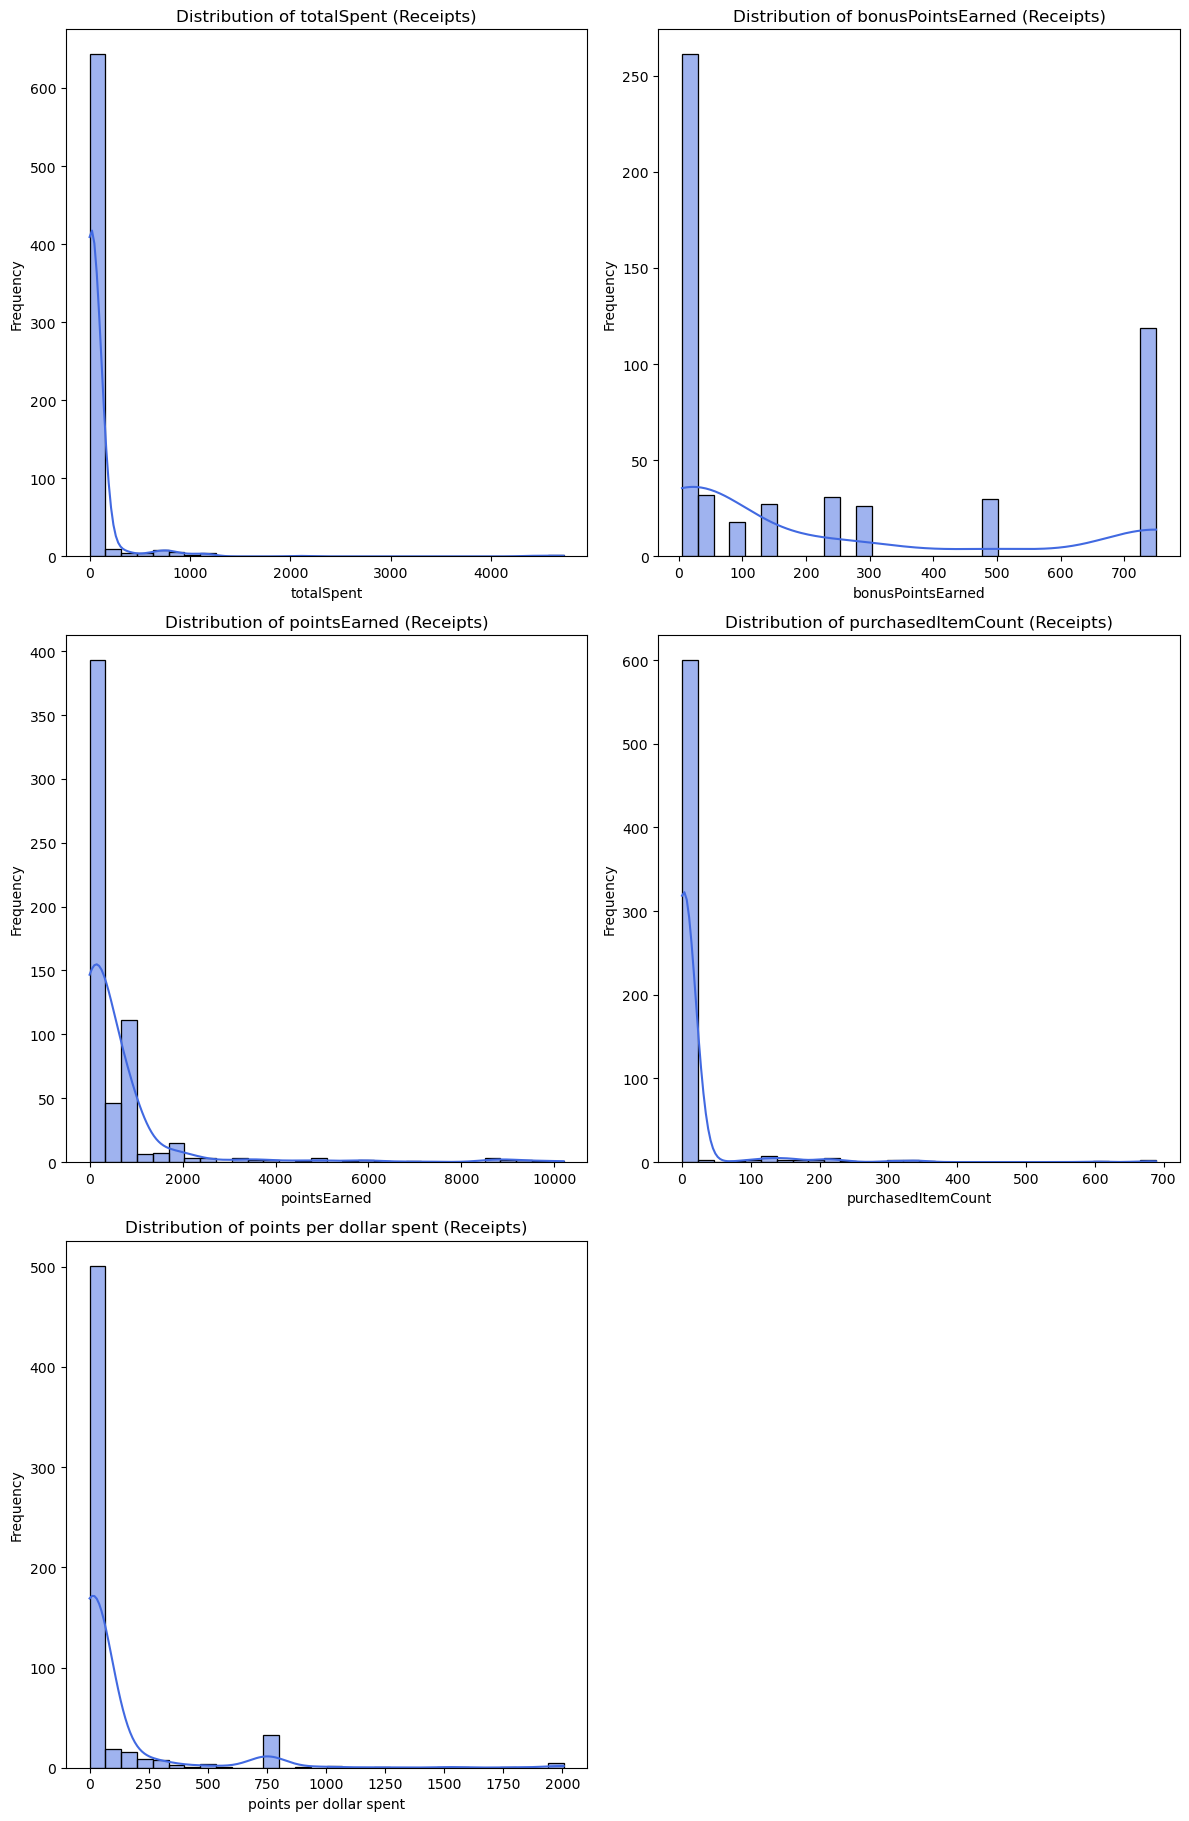

In [315]:
plot_distributions(receipts, 'Receipts', ['totalSpent','bonusPointsEarned','pointsEarned','purchasedItemCount','points per dollar spent'])

In [310]:
# Check top total spent rows
receipts.sort_values(by = 'totalSpent', ascending = False).head()

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptStatus,totalSpent,userId
469,600f39c30a7214ada2000030,750.0,"Receipt number 1 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-25 21:36:03,2021-01-25 21:36:03,2021-01-26 03:06:03,2021-01-26 03:07:40,2021-01-26 03:06:03,7137.2,2021-01-24,670.0,FINISHED,4721.95,600f35015edb782098e2ac1b
543,600f2fc80a720f0535000030,750.0,"Receipt number 1 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-25 20:53:28,2021-01-25 20:53:28,2021-01-25 22:04:23,2021-01-28 22:37:02,2021-01-25 22:04:23,4944.7,2021-01-24,689.0,FINISHED,4566.17,600f29a64329897eac239049
446,600f24970a720f053500002f,NaN,NaN,2021-01-25 20:05:43,2021-01-25 20:05:43,NaT,2021-01-25 20:25:25,NaT,NaN,2021-01-25,599.0,FLAGGED,4368.80,600f20c15edb787dce060911
447,600f0cc70a720f053500002c,NaN,NaN,2021-01-25 18:24:07,2021-01-25 18:24:07,NaT,2021-01-25 18:38:07,NaT,NaN,2021-01-25,303.0,FLAGGED,2084.82,600f00d05edb787dce05fb84
419,600996ac0a720f05fa000134,750.0,"Receipt number 1 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-21 14:58:52,2021-01-21 14:58:52,2021-01-21 15:11:25,2021-01-21 15:16:08,2021-01-21 15:11:25,6257.3,2021-01-17,348.0,FINISHED,1198.68,6009969150b33111fd61f6d9


In [311]:
# Check top bonusPointsEarned rows
receipts.sort_values(by = 'bonusPointsEarned', ascending = False).head()

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptStatus,totalSpent,userId
196,5ffcb48d0a7214ad4e000002,750.0,"Receipt number 1 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-11 20:26:53,2021-01-11 20:26:53,NaT,2021-01-11 20:26:55,2021-01-11 20:26:55,750.0,2021-01-10 20:26:53,1.0,FLAGGED,1.00,5ffcb48d04929111f6e92594
650,601830ce0a7214ad500002df,750.0,"Receipt number 1 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-02-01 16:48:14,2021-02-01 16:48:14,2021-02-01 16:48:15,2021-02-01 16:48:19,2021-02-01 16:48:15,750.0,2021-02-01 00:00:00,5.0,FINISHED,28.00,601830ce9a1b091205b618e8
209,5ffc8f990a7214adca00002d,750.0,"Receipt number 1 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-11 17:49:13,2021-01-11 17:49:13,2021-01-11 17:49:18,2021-01-11 17:49:18,2021-01-11 17:49:18,885.0,2021-01-10 17:49:13,2.0,FINISHED,2.00,5ffc8f9704929111f6e922bf
246,5ffe17e20a720f05ac0000e7,750.0,"Receipt number 1 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-12 21:42:58,2021-01-12 21:42:58,NaT,2021-01-13 16:00:54,NaT,750.0,2021-01-12 00:00:00,1.0,REJECTED,2.29,5ffe115404929101d0aaebb2
247,5fff561b0a720f05f300002e,750.0,"Receipt number 1 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-13 20:20:43,2021-01-13 20:20:43,2021-01-13 20:20:45,2021-01-13 20:20:45,2021-01-13 20:20:45,1750.0,2021-01-13 20:20:43,1.0,FINISHED,10.00,5fff561abd4dff11dda8fa2b


In [380]:
# Check top pointsEarned rows
receipts.sort_values(by = 'pointsEarned', ascending = False).head()

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptStatus,totalSpent,userId,points per dollar spent
492,6011f3490a7214ada200010e,5.0,All-receipts receipt bonus,2021-01-27 23:12:09,2021-01-27 23:12:09,2021-01-27 23:12:11,2021-01-27 23:12:15,2021-01-27 23:12:11,10199.8,2021-01-26 23:12:09,2.0,FINISHED,11.0,6011f31ea4b74c18d3a8c476,927.254545
374,60088d580a7214ad890000eb,750.0,"Receipt number 1 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-20 20:06:48,2021-01-20 20:06:48,2021-01-20 20:06:49,2021-01-20 20:06:54,2021-01-20 20:06:49,9850.0,2021-01-20 00:00:00,7.0,FINISHED,26.0,60088d58633aab121bb8e424,378.846154
78,5fa5ad370a720f05ef000089,750.0,"Receipt number 1 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2020-11-06 20:08:23,2020-11-06 20:08:23,2021-01-05 20:53:40,2021-01-05 20:53:40,2021-01-05 20:53:40,9449.8,2020-11-05 20:08:23,11.0,FINISHED,291.0,5fa5ad376a26f611e71ab5ef,32.473540
158,5ff873f10a720f052300064f,500.0,"Receipt number 2 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-08 15:02:09,2021-01-08 15:02:09,NaT,2021-01-08 15:02:10,NaT,9200.0,2021-02-08 15:02:10,10.0,FLAGGED,290.0,5ff873d1b3348b11c9337716,31.724138
190,5ffcb4900a720f0515000002,250.0,"Receipt number 3 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-11 20:26:56,2021-01-11 20:26:56,NaT,2021-01-11 20:26:57,NaT,8950.0,2021-02-11 20:26:56,10.0,FLAGGED,290.0,5ffcb47d04929111f6e9256c,30.862069


In [381]:
# Check top purchasedItemCount rows
receipts.sort_values(by = 'purchasedItemCount', ascending = False).head()

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptStatus,totalSpent,userId,points per dollar spent
543,600f2fc80a720f0535000030,750.0,"Receipt number 1 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-25 20:53:28,2021-01-25 20:53:28,2021-01-25 22:04:23,2021-01-28 22:37:02,2021-01-25 22:04:23,4944.7,2021-01-24,689.0,FINISHED,4566.17,600f29a64329897eac239049,1.082899
469,600f39c30a7214ada2000030,750.0,"Receipt number 1 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-25 21:36:03,2021-01-25 21:36:03,2021-01-26 03:06:03,2021-01-26 03:07:40,2021-01-26 03:06:03,7137.2,2021-01-24,670.0,FINISHED,4721.95,600f35015edb782098e2ac1b,1.511494
446,600f24970a720f053500002f,NaN,NaN,2021-01-25 20:05:43,2021-01-25 20:05:43,NaT,2021-01-25 20:25:25,NaT,NaN,2021-01-25,599.0,FLAGGED,4368.80,600f20c15edb787dce060911,NaN
419,600996ac0a720f05fa000134,750.0,"Receipt number 1 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-21 14:58:52,2021-01-21 14:58:52,2021-01-21 15:11:25,2021-01-21 15:16:08,2021-01-21 15:11:25,6257.3,2021-01-17,348.0,FINISHED,1198.68,6009969150b33111fd61f6d9,5.220159
407,60099c3c0a7214ad89000135,750.0,"Receipt number 1 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-21 15:22:36,2021-01-21 15:22:36,2021-01-21 15:28:37,2021-01-21 15:31:10,2021-01-21 15:28:37,4480.5,2021-01-21,341.0,FINISHED,1083.24,60099c1450b33111fd61f702,4.136203


In [384]:
# Check top points per dollar spent rows
receipts.sort_values(by = 'points per dollar spent', ascending = False).head()

,_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptStatus,totalSpent,userId,points per dollar spent
424,600aff160a720f053500000c,500.0,"Receipt number 2 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-22 16:36:38,2021-01-22 16:36:38,2021-01-22 16:37:01,2021-01-22 16:37:13,2021-01-22 16:37:01,500.0,2021-01-22 00:00:00,0.0,FINISHED,0.0,600afb2a7d983a124e9aded0,inf
396,6009eb000a7214ada2000003,250.0,"Receipt number 3 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)",2021-01-21 20:58:40,2021-01-21 20:58:40,2021-01-21 20:59:06,2021-01-21 20:59:15,2021-01-21 20:59:06,250.0,2021-01-21 00:00:00,0.0,FINISHED,0.0,6009e60450b3311194385009,inf
248,5fff26fd0a720f05f300001d,5.0,All-receipts receipt bonus,2021-01-13 16:59:41,2021-01-13 16:59:41,NaT,2021-01-13 16:59:41,2021-01-13 16:59:41,2005.0,2021-01-12 16:59:41,1.0,FLAGGED,1.0,5fff2698b3348b03eb45bb10,2005.0
127,5ff794020a720f0523000635,5.0,All-receipts receipt bonus,2021-01-06 05:06:42,2021-01-06 05:06:42,2021-01-07 11:06:44,2021-01-07 17:06:46,2021-01-07 11:06:44,2005.0,2021-01-05 05:06:42,1.0,FINISHED,1.0,5ff7930fb3348b11c93372a6,2005.0
143,5ff7942e0a720f0523000637,5.0,All-receipts receipt bonus,2021-01-05 23:07:26,2021-01-05 23:07:26,2021-01-07 23:07:36,2021-01-07 23:07:36,2021-01-07 05:07:29,2005.0,2021-01-04 23:07:26,2.0,FINISHED,1.0,5ff7930fb3348b11c93372a6,2005.0


#### itemList

The itemList table has very high missing value rate for most columns, which can impact the distribution analysis of numeric columns. To ensure reliable analysis, only a few key columns with a low missing value rate are checked here.

Again, the distributions of finalPrice, itemPrice, and quantityPurchased exhibit strong right-skewness, with most values concentrated near zero.

1. Final Price & Item Price:

    - The majority of items are priced below \$10, but there are a few extreme values above 400, which needs discussion with stakeholders to see if that aligns with the business. 

2. Quantity Purchased:

    - Most purchases involve single or low-quantity items.
    - Some product show high purchase quantities (10-16 items), which is possible for bulk purchases.

In [317]:
itemList.dtypes

_id                                    object
barcode                                object
description                            object
finalPrice                            float64
itemPrice                             float64
needsFetchReview                       object
partnerItemId                          object
preventTargetGapPoints                 object
quantityPurchased                     float64
userFlaggedBarcode                     object
userFlaggedNewItem                     object
userFlaggedPrice                       object
userFlaggedQuantity                   float64
needsFetchReviewReason                 object
pointsNotAwardedReason                 object
pointsPayerId                          object
rewardsGroup                           object
rewardsProductPartnerId                object
userFlaggedDescription                 object
originalMetaBriteBarcode               object
originalMetaBriteDescription           object
brandCode                         

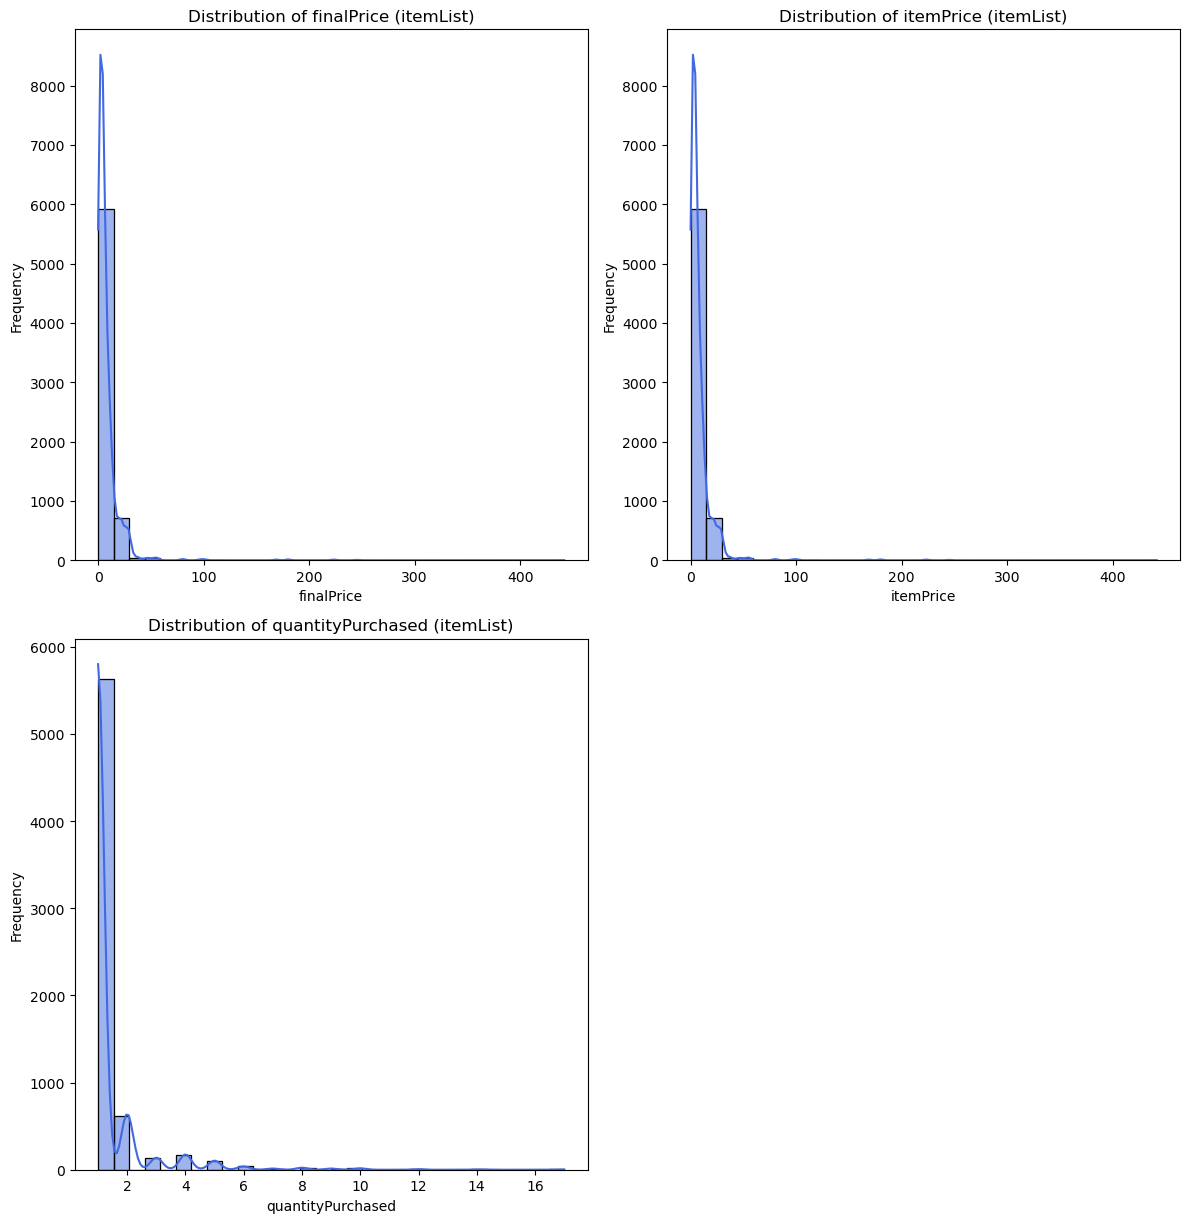

In [385]:
plot_distributions(itemList, 'itemList', ['finalPrice','itemPrice','quantityPurchased'])

In [387]:
# Check top finalPrice rows
itemList.sort_values(by = 'itemPrice', ascending = False).head()

,_id,barcode,description,finalPrice,itemPrice,needsFetchReview,partnerItemId,preventTargetGapPoints,quantityPurchased,userFlaggedBarcode,userFlaggedNewItem,userFlaggedPrice,userFlaggedQuantity,needsFetchReviewReason,pointsNotAwardedReason,pointsPayerId,rewardsGroup,rewardsProductPartnerId,userFlaggedDescription,originalMetaBriteBarcode,originalMetaBriteDescription,brandCode,competitorRewardsGroup,discountedItemPrice,originalReceiptItemText,itemNumber,originalMetaBriteQuantityPurchased,pointsEarned,targetPrice,competitiveProduct,originalFinalPrice,originalMetaBriteItemPrice,deleted,priceAfterCoupon,metabriteCampaignId,calculated_item_price
4540,600ba6ae0a7214ada2000010,NaN,DOLE PINEAPPLE CHUNKS IN 10C,441.58,441.58,NaN,1350,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,441.58,DOLE PINEAPPLE CHUNKS IN 10C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,441.58
6438,600f2fc80a720f0535000030,NaN,GRAPE RASP,245.00,245.00,False,1506,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245.00,GRAPE RASP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.50
4981,600f24970a720f053500002f,NaN,GRAPE RASP,245.00,245.00,NaN,1499,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245.00,GRAPE RASP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.50
5789,600f39c30a7214ada2000030,NaN,GRAPE RASP,245.00,245.00,NaN,1485,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245.00,GRAPE RASP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245.0,NaN,17.50
6375,600f2fc80a720f0535000030,021834033316,HMPL CRD PPR SLCD PRK BCN WRP 20 OZ,223.36,223.36,False,1352,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,559c2234e4b06aca36af13c6,NaN,NaN,NaN,HEMPLER'S,OSCAR MAYER BACON,223.36,HEMPLERS S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.92


In [388]:
# Check top quantityPurchased rows
itemList.sort_values(by = 'quantityPurchased', ascending = False).head()

,_id,barcode,description,finalPrice,itemPrice,needsFetchReview,partnerItemId,preventTargetGapPoints,quantityPurchased,userFlaggedBarcode,userFlaggedNewItem,userFlaggedPrice,userFlaggedQuantity,needsFetchReviewReason,pointsNotAwardedReason,pointsPayerId,rewardsGroup,rewardsProductPartnerId,userFlaggedDescription,originalMetaBriteBarcode,originalMetaBriteDescription,brandCode,competitorRewardsGroup,discountedItemPrice,originalReceiptItemText,itemNumber,originalMetaBriteQuantityPurchased,pointsEarned,targetPrice,competitiveProduct,originalFinalPrice,originalMetaBriteItemPrice,deleted,priceAfterCoupon,metabriteCampaignId,calculated_item_price
5758,600f39c30a7214ada2000030,NaN,PAGASA PAS,54.91,54.91,NaN,1424,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.91,PAGASA PAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.91,NaN,3.23
6412,600f2fc80a720f0535000030,NaN,PAGASA PAS,54.91,54.91,False,1448,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.91,PAGASA PAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.23
4938,600f24970a720f053500002f,NaN,PAGASA PAS,54.91,54.91,NaN,1414,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.91,PAGASA PAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.23
5789,600f39c30a7214ada2000030,NaN,GRAPE RASP,245.00,245.00,NaN,1485,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245.00,GRAPE RASP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245.00,NaN,17.50
6438,600f2fc80a720f0535000030,NaN,GRAPE RASP,245.00,245.00,False,1506,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245.00,GRAPE RASP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.50


### 3.4 Joining Keys

Here, we examine the joining keys between tables to ensure a high matching rate when linking them together for analysis.

In [328]:
# Create in-memory sqlite database
conn = sqlite3.connect(":memory:")

# Load data into SQL tables
users.to_sql("users", conn, index=False, if_exists="replace")
receipts.to_sql("receipts", conn, index=False, if_exists="replace")
itemList.to_sql("itemlist", conn, index=False, if_exists="replace")
brands.to_sql("brands", conn, index=False, if_exists="replace")

1167

#### 3.4.1Join Receipts to Users table

- Out of 1,119 unique receipts from 258 users, 148 receipts (13%) and 117 users (45%) cannot be mapped in the users table. This suggests a delay in syncing between receipts and user data. For accurate customer-level analysis, it's recommended to wait until user information is fully updated across tables.

In [354]:
query1 = """
SELECT 
CASE WHEN u._id IS NULL THEN 'NO MATCH' ELSE 'MATCH' END AS Match,
COUNT(DISTINCT r._id),
COUNT(DISTINCT r.userId)
FROM receipts r
LEFT JOIN users u ON r.userId = u._id 
GROUP BY 1

"""

pd.read_sql(query1, conn)

,Match,COUNT(DISTINCT r._id),COUNT(DISTINCT r.userId)
0,MATCH,971,141
1,NO MATCH,148,117


#### 3.4.2 Join Receipts to Itemlist table

- Out of 1,119 unique receipts, 440 (39%) lack itemlist information, leaving the purchased items unknown.

In [348]:
query1 = """

SELECT 
CASE WHEN i._id IS NULL THEN 'NO MATCH' ELSE 'MATCH' END AS Match,
COUNT(DISTINCT r._id) 
FROM receipts r
LEFT JOIN itemlist i ON r._id = i._id 
GROUP BY 1

"""

pd.read_sql(query1, conn)

,Match,COUNT(DISTINCT r._id)
0,MATCH,679
1,NO MATCH,440


- Among the 440 receipts missing itemlist information, 434 (99%) are in the 'Submitted' category under rewardsReceiptStatus. Item-level analysis should be conducted only after receipts are fully processed.

In [347]:
query1 = """

SELECT 
rewardsReceiptStatus,
CASE WHEN i._id IS NULL THEN 'NO MATCH' ELSE 'MATCH' END AS Match,
COUNT(DISTINCT r._id) 
FROM receipts r
LEFT JOIN itemlist i ON r._id = i._id 
GROUP BY 1, 2
ORDER BY 1, 2

"""

pd.read_sql(query1, conn)

,rewardsReceiptStatus,Match,COUNT(DISTINCT r._id)
0,FINISHED,MATCH,516
1,FINISHED,NO MATCH,2
2,FLAGGED,MATCH,46
3,PENDING,MATCH,49
4,PENDING,NO MATCH,1
5,REJECTED,MATCH,68
6,REJECTED,NO MATCH,3
7,SUBMITTED,NO MATCH,434


#### 3.4.3 Join Itemlist to Brands table

- The itemlist and brands tables are joined via barcode, but over half of the records (3,851 out of 6,948, 55%) in itemlist have null barcodes. Among the valid barcodes, only 89 records (16 out of 568 unique barcodes) match the brands table, limiting brand-level analysis.

In [358]:
query1 = """

SELECT 
CASE WHEN i.barcode IS NULL THEN 'NULL' ELSE 'NOT NULL' END AS BARCODE_NULL,
CASE WHEN b.barcode IS NULL THEN 'NO MATCH' ELSE 'MATCH' END AS Match,
COUNT(*),
COUNT(DISTINCT i.barcode)
FROM itemlist i
LEFT JOIN brands b ON i.barcode = b.barcode 
GROUP BY 1, 2

"""

pd.read_sql(query1, conn)

,BARCODE_NULL,Match,COUNT(*),COUNT(DISTINCT i.barcode)
0,NOT NULL,MATCH,89,16
1,NOT NULL,NO MATCH,3008,552
2,NULL,NO MATCH,3851,0
